In [569]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [570]:
df_solar_satellite = pd.read_csv('../1_data_analysis_and_preproc/intermediate/solar/df_solar_satellite.csv')

In [571]:
df_solar_satellite.head()

,asset_id,read_at,dc_power,dc_voltage,dc_current,global_tilted_irradiance,global_horizontal_irradiance,temperature,cloud_cover
0,11,2022-01-01 08:10:00,60.6247,275.567,0.220,2.0,2.0,12.3,46.1
1,11,2022-01-01 08:20:00,157.1340,301.600,0.521,9.0,9.0,12.4,56.1
2,11,2022-01-01 08:30:00,297.7330,313.733,0.949,52.0,29.0,12.6,37.2
3,11,2022-01-01 08:40:00,645.5820,323.600,1.995,126.0,55.0,12.7,12.5
4,11,2022-01-01 08:50:00,617.0240,321.367,1.920,235.0,83.0,12.9,3.0


In [572]:
np.random.seed(10)

asset = df_solar_satellite['asset_id'].unique()[0]

length = len(df_solar_satellite[df_solar_satellite['asset_id'] == asset])

subset_size = int(0.015 * length)  # Adjust the percentage as needed

# Group the DataFrame by the asset identifier column(s)
grouped = df_solar_satellite.groupby('asset_id')

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each group, sample subset_size rows from each group, and append to subset_data
for _, group_df in grouped:
    sampled_group = group_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all groups into a single DataFrame
df_subset = pd.concat(subset_data)

In [573]:
len(df_subset)

48587

In [574]:
df_subset['asset_id'].nunique()

77

In [575]:
df_subset = df_subset.reset_index(drop=True)

In [576]:
n_components = 2
pca = PCA(n_components=n_components)

the variables to include for the model should be dc_power, dc_voltage, dc_current, temperature and cloud_cover, as global_tilted_irradiance and global_horizontal_irradiance have very high correlation with other variables and keeping them, would be reductant

however, in the time series clustering, we'll want to do one variable at a time and then all of them.

In [577]:
X = df_subset.loc[:, 'dc_power':].drop(columns = ['global_tilted_irradiance','global_horizontal_irradiance'])
X = X.reset_index(drop=True)
X.head()

,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,311.415,301.467,1.033,15.0,0.0
1,5503.840,281.800,19.531,24.7,0.0
2,1046.530,326.633,3.204,10.9,52.8
3,4640.730,296.400,15.657,19.5,0.0
4,628.495,313.933,2.002,9.0,20.0


In [578]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

pca_df.head()

,PC1,PC2
0,0.105048,-2.351425
1,2.457331,-2.791890
2,-1.285060,-2.345703
3,1.629694,-2.557912
4,-0.842601,-2.301941


In [579]:
pca_df['read_at'] = df_subset['read_at']

In [580]:
# import rpy2.robjects.packages as rpackages
# from rpy2.robjects import r

# # Install and import the necessary R packages
# utils = rpackages.importr('utils')

In [581]:
# utils.install_packages('dtwclust')

In [582]:
# dtwclust = rpackages.importr('dtwclust')

In [583]:
# import rpy2.robjects as ro
# from rpy2.robjects import pandas2ri

# # Activate pandas conversion
# pandas2ri.activate()

# # Convert pandas DataFrame to R object
# r_data = pandas2ri.py2rpy(pca_df)

In [584]:
# Perform time series clustering using dtwclust package
# clusters = dtwclust.dtwclust(r_data)

In [585]:
X['read_at'] = df_subset['read_at']
X['asset_id'] = df_subset['asset_id']

In [586]:
X = X[['asset_id','read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']]
X.head()

,asset_id,read_at,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,11,2022-09-01 07:10:00,311.415,301.467,1.033,15.0,0.0
1,11,2022-05-11 14:30:00,5503.840,281.800,19.531,24.7,0.0
2,11,2022-04-22 15:40:00,1046.530,326.633,3.204,10.9,52.8
3,11,2022-05-04 09:20:00,4640.730,296.400,15.657,19.5,0.0
4,11,2023-01-18 16:10:00,628.495,313.933,2.002,9.0,20.0


In [587]:
X.dtypes

asset_id         int64
read_at         object
dc_power       float64
dc_voltage     float64
dc_current     float64
temperature    float64
cloud_cover    float64
dtype: object

In [588]:
X['read_at'] = pd.to_datetime(X['read_at'])

In [589]:
X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

In [590]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48587 entries, 0 to 48586
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     48587 non-null  int64  
 1   read_at      48587 non-null  float64
 2   dc_power     48587 non-null  float64
 3   dc_voltage   48587 non-null  float64
 4   dc_current   48587 non-null  float64
 5   temperature  48587 non-null  float64
 6   cloud_cover  48587 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.6 MB


In [591]:
X = X.astype(np.float32)

In [592]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48587 entries, 0 to 48586
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     48587 non-null  float32
 1   read_at      48587 non-null  float32
 2   dc_power     48587 non-null  float32
 3   dc_voltage   48587 non-null  float32
 4   dc_current   48587 non-null  float32
 5   temperature  48587 non-null  float32
 6   cloud_cover  48587 non-null  float32
dtypes: float32(7)
memory usage: 1.3 MB


In [593]:
X_grouped = X.groupby('asset_id')

In [594]:
# Assuming df_subset is your DataFrame containing the 'asset_id' column
# Count the number of rows for each asset ID
rows_per_asset = df_subset['asset_id'].value_counts()

# Display the result
print(rows_per_asset.nunique())

1


In [595]:
X

,asset_id,read_at,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,11.0,1.662016e+09,311.415009,301.467010,1.0330,15.000000,0.000000
1,11.0,1.652279e+09,5503.839844,281.799988,19.5310,24.700001,0.000000
2,11.0,1.650642e+09,1046.530029,326.632996,3.2040,10.900000,52.799999
3,11.0,1.651656e+09,4640.729980,296.399994,15.6570,19.500000,0.000000
4,11.0,1.674058e+09,628.494995,313.933014,2.0020,9.000000,20.000000
...,...,...,...,...,...,...,...
48582,514.0,1.693420e+09,4499.229980,525.280029,0.3565,19.000000,3.000000
48583,514.0,1.695569e+09,67256.296875,516.280029,5.4015,22.000000,0.000000
48584,514.0,1.702562e+09,74401.101562,532.330017,5.7980,14.000000,0.000000
48585,514.0,1.703675e+09,32756.199219,548.900024,2.4755,13.000000,36.000000


In [596]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays = [group[['read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']].values \
                    for _, group in X.groupby('asset_id')]

print(grouped_arrays)

[array([[1.6620163e+09, 3.1141501e+02, 3.0146701e+02, 1.0330000e+00,
        1.5000000e+01, 0.0000000e+00],
       [1.6522794e+09, 5.5038398e+03, 2.8179999e+02, 1.9531000e+01,
        2.4700001e+01, 0.0000000e+00],
       [1.6506420e+09, 1.0465300e+03, 3.2663300e+02, 3.2040000e+00,
        1.0900000e+01, 5.2799999e+01],
       ...,
       [1.6754982e+09, 7.1043597e+02, 3.2439999e+02, 2.1900001e+00,
        4.0000000e+00, 0.0000000e+00],
       [1.7026422e+09, 4.8055000e+03, 3.0850000e+02, 1.5577000e+01,
        1.4000000e+01, 0.0000000e+00],
       [1.6784424e+09, 1.1419500e+03, 3.1450000e+02, 3.6310000e+00,
        1.6000000e+01, 4.8000000e+01]], dtype=float32), array([[1.6502909e+09, 1.0080000e+03, 2.5779999e+02, 3.9100001e+00,
        1.7200001e+01, 6.6699997e+01],
       [1.6415700e+09, 1.6310500e+03, 2.5633301e+02, 6.3629999e+00,
        1.3500000e+01, 0.0000000e+00],
       [1.6562646e+09, 1.1469301e+03, 2.5510001e+02, 4.4959998e+00,
        1.8000000e+01, 0.0000000e+00],
       

In [597]:
num_arrays = len(grouped_arrays)
num_arrays

77

In [598]:
X_train = grouped_arrays

In [599]:
seed = 42

Euclidean k-means
1049.335 --> 559.967 --> 558.220 --> 558.220 --> 


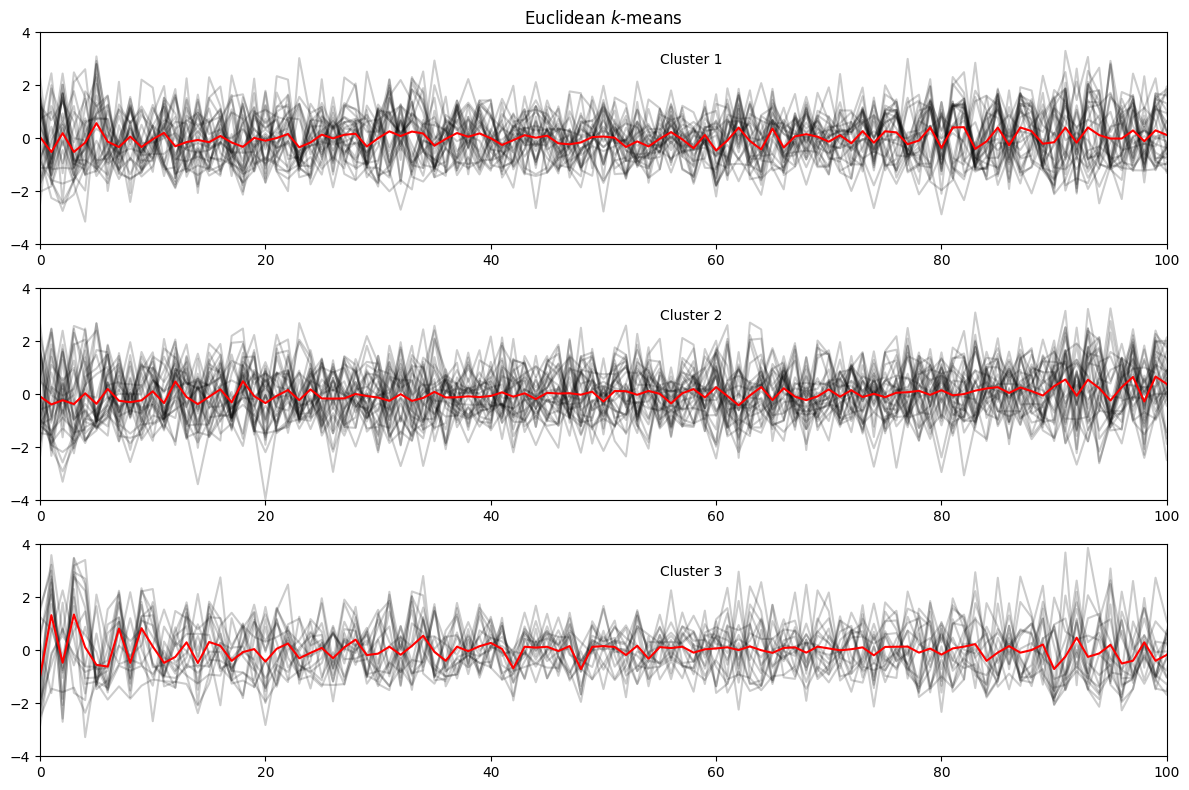

In [611]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure(figsize=(12, 8))
for yi in range(3):
    plt.subplot(3, 1, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85, 'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Euclidean $k$-means")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


DBA k-means
Init 1
672.201 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


403.612 --> 401.915 --> 401.915 --> 

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s



Init 2
674.606 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


405.475 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


402.891 --> 402.891 --> 


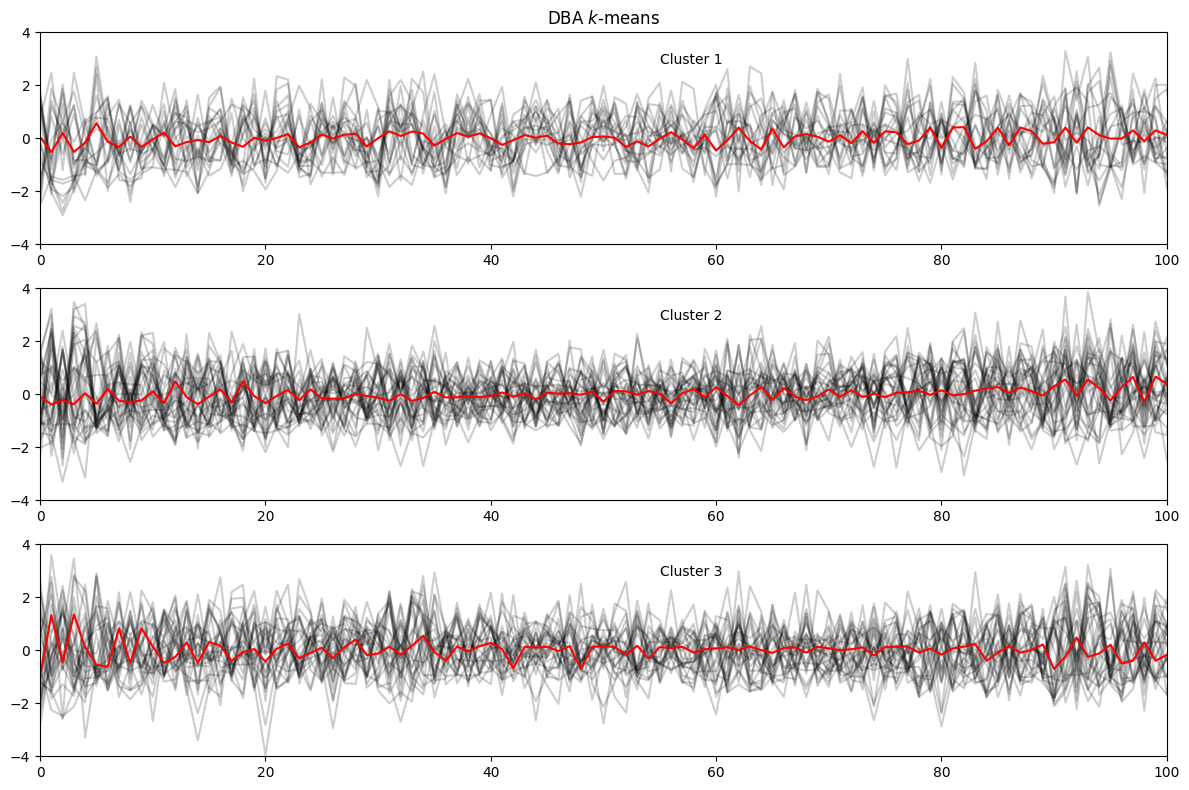

In [610]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

plt.figure(figsize=(12, 8))
for yi in range(3):
    plt.subplot(3, 1, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85, 'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


Soft-DTW k-means
472705.044 --> 165318.835 --> 164923.723 --> 164800.531 --> 164724.516 --> 164651.192 --> 164640.729 --> 164636.217 --> 164631.336 --> 164627.041 --> 164627.029 --> 164626.203 --> 164624.510 --> 164624.492 --> 164624.466 --> 164624.468 --> 164624.451 --> 164624.450 --> 164624.453 --> 164624.453 --> 


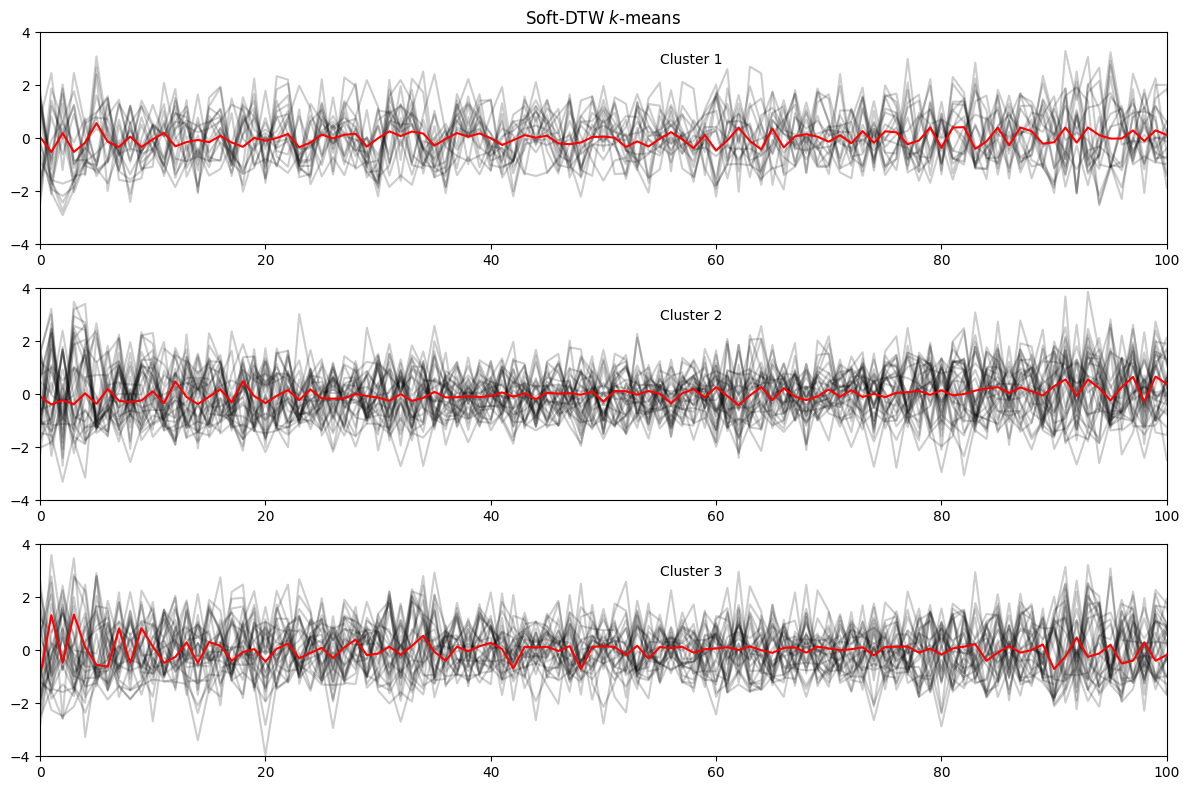

In [612]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

plt.figure(figsize=(12, 8))
for yi in range(3):
    plt.subplot(3, 1, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85, 'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Soft-DTW $k$-means")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()